## Load Packages

In [1]:
import pandas as pd
import numpy as np
from numpy import meshgrid
import os
import netCDF4 as nc
from netCDF4 import Dataset as ds
import math


import matplotlib as mpl
import matplotlib
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.pyplot as plt

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import imageio

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap


top2 = cm.get_cmap('winter')
bottom2 = cm.get_cmap('hot_r')
newcolors2 = np.vstack((top2(np.linspace(0, 1, 128)),   # I want all of the winter cmap and it will only explain 100 points
                    bottom2(np.linspace(.1, .9, 128)))) # I dont want the extremes of hot cmap but it will explain 128 points
newcmp2 = ListedColormap(newcolors2, name='OrangeBlue')
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug','Sep', 'Oct', 'Nov', 'Dec']


C:\Users\bubby\AppData\Local\Temp\ipykernel_19304\435426302.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  top2 = cm.get_cmap('winter')
C:\Users\bubby\AppData\Local\Temp\ipykernel_19304\435426302.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  bottom2 = cm.get_cmap('hot_r')


## Define Functions

In [2]:

def set_directory():
    global data_directory
    path = 'F:/GLORYS/'
    if not os.path.exists(path):
        data_directory = '/Volumes/Elements/GLORYS'
    else:
        data_directory = path
    return

#################################################################################################################
#################################################################################################################

# Function creates a folder if it doesnt already exist
# Input:
#         - folder_path: string with the path name to folder

def create_folder(folder_path):
    
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        print(f"Folder '{folder_path}' created.")
    else:
        print(f"Folder '{folder_path}' already exists.")
set_directory()

#################################################################################################################
#################################################################################################################
# Function compute volume weights based on latitude and depthe values. Although longitude values are not
# in the equation the length of the longitude array is necessary for building 3D volume weight array 
# Input:
#         - lat: 1d array with all latitude values
#         - lon: 1d array with all longitude values
#         - depth: 1d array with all depth values
# Output: 
#         - area_weight: 3D array 
def vol_weight(depths, lon, lat):
    xx, yy = meshgrid(lon, lat)
    tot_depth = len(depths)
    
    # area weight for lattitude values
    area_w = np.cos(yy*math.pi/180)
    if lat[-1] == 90.0:
        area_w[-1,:] = 0.0
    # area weights for depth
    area_weight = []
    for i in range(tot_depth):
        if i == 0:
            area_weight.append(np.sqrt(depths[0] * area_w)) # first depth thickness
        else:
            area_weight.append( np.sqrt((depths[i] - depths[i - 1]) * area_w))
    # Turning weights into one array
    area_weight = np.array(area_weight)
    return area_weight

#################################################################################################################
#################################################################################################################

# Function formats longitude to get rid of degree symbols
# Input:
#         - longitude: numeric corresponding to parallel


def format_longitude(longitude):
    if not 0 <= longitude <= 360:
        return "Invalid longitude. Must be between 0 and 360 degrees."
    
    if longitude == 0:
        hemisphere = ''
        degrees = longitude
    elif longitude < 180:
        hemisphere = 'E'
        degrees = longitude
    elif longitude == 180:
        hemisphere = ''
        degrees = longitude
    else:
        hemisphere = 'W'
        degrees = 360 - longitude

    return f"{degrees:.0f}{hemisphere}"


#################################################################################################################
#################################################################################################################

# Function formats latitude to get rid of degree symbols
# Input:
#         - latitude: numeric corresponding to meridian


def format_latitude(latitude):
    if not -90 <= latitude <= 90:
        return "Invalid latitude. Must be between -90 and 90 degrees."
    
    if latitude > 0:
        hemisphere = "N"    
    elif latitude == 0:
        hemisphere = ""
    else: 
        hemisphere = 'S'
    
    degrees = abs(latitude)

    return f"{degrees:.0f}{hemisphere}"




#################################################################################################################
#################################################################################################################
# Function converts longitude from 0 to 360 to centered at 180. This is just for naming purposes.
# it does not shift the axis of the data
# Input:
#         - lon_0_360: float with the longitude value from 0 to 360
# Output:
#         - convert: String with the longitude value on a 180 centered scale

# Important Variables:
#         - lon_180_w_180_e: float with the longitude value on a 180 centered scale
def convert_longitude(lon_0_360):
    lon_180_w_180_e = lon_0_360 - 360 if lon_0_360 > 180 else lon_0_360
    if lon_180_w_180_e < 0:
        lon_180_w_180_e = abs(lon_180_w_180_e)
        convert = f"{lon_180_w_180_e}$^\xb0$W"
    else:
        convert = f"{lon_180_w_180_e}$^\xb0$E"
    return convert
#################################################################################################################
#################################################################################################################
# function turns lat name into an int and a string for a title
# Input:
#         - lat_ind: int with the index of the cut_lon array being plotted
# Output:
#         -lat_name: strng with the rounded lat name with South or North appended
# Important Variables:
#         -cut_lat: float array with lattitude values
def get_lat_names(lat_ind):
    lat_name = int(cut_lat[lat_ind])
    if lat_name< 0:
        lat_name =  f"{abs(lat_name)}$^\xb0$S"
    elif lat_name == 0:
        lat_name = 'Equator'
    else:
        lat_name =  f"{lat_name}$^\xb0$N"
    return lat_name
#################################################################################################################
#################################################################################################################
# Function get_var() will get common variables that will be required for climatologies,
# anomalies, and EOFs. It will pull these from raw GLORYs data
# Input:
# Output:
#         - lat: 1d array with all latitude values
#         - lon: 1d array with all longitude values
#         - depth: 1d array with all depth values
#         - years: 1d array with all year values
def get_var(data_directory):
    fn     = prefix + '.mon.clim.nc'             # name of the file
    fn     = os.path.join(data_directory, fn)
    fn     =  ds(fn,'r')
    lat    = fn.variables['lat'][:].data    # read in latitude
    lon    = fn.variables['lon'][:].data   # read in longitude
    depths = fn.variables['Z'][:].data       # read in depth
    fn.close()
    return lat, lon, depths


## Define Variables

In [3]:
month = 'Winter Avg'


fn     = 'Anomalies/Jan/Jan.anom.mon.1993.nc'
fn     = os.path.join(data_directory, fn)
fn     =  ds(fn,'r')
lat    = fn.variables['lat'][:].data    # read in latitude
lon    = fn.variables['lon'][:].data   # read in longitude
depths = fn.variables['Z'][:].data       # read in depth
fn.close()


####### SELECT REGION ########

# region = "Pacific"


# # for the entire Pacific
# lat_start = 720
# lat_end   = 1801
# lon_start = 1440
# lon_end   = 3600

# Not sure which one to do
#depth_end = len(depths)
depth_end = 32


region = "Global"

# Global
lat_start = 0
lat_end   = len(lat)
lon_start = 0
lon_end   = len(lon)
depth_end = len(depths)


############################




EOF_directory  = os.path.join(data_directory, '2D EOFs/' + month + "/" +region + "/")
create_folder(EOF_directory)
anomalies_directory = os.path.join(data_directory, 'Anomalies/Winter Avg' )




years  = np.linspace(1994, 2021,28, dtype="int")
cut_lat = lat[lat_start:lat_end]
cut_lon = lon[lon_start:lon_end]
cut_depths = depths[:depth_end]



Folder 'F:/GLORYS/2D EOFs/Winter Avg/Global/' already exists.


### Read in Data

In [10]:
# EOF Mode of Interest

mode = 3

#################################################################
#### 2D 
#################################################################
# Read in files
fn      = 'EOF_'+str(mode)+'.nc'
fn      = os.path.join(EOF_directory, fn)     # join with EOF path
EOF_ncfile = ds(fn, 'r')
EOF = EOF_ncfile.variables['EOF']
EOF = EOF[:].filled()
EOF_ncfile.close()

# Calculate
area_weight = vol_weight(cut_depths, cut_lon, cut_lat)
EOF = EOF/area_weight  # remember to div by area weight 


# Correct negatively oriented layers by mode

if region == 'Pacific':
    # For Pacific
    noiseLayers1 = [8, 9, 10, 11, 14, 15, 16, 17, 18, 19, 21, 22, 24, 25, 28, 31]
    noiseLayers2 = [0, 4, 5, 9, 11, 14, 15, 16, 18, 20, 23, 25, 26, 27, 29, 30, 31]
    print('pacific')
elif region == "Global":
    noiseLayers1 = [8, 9, 13, 14, 15, 17, 19, 20, 24, 25, 29, 30, 34, 36, 37, 38, 39, 40, 42, 44, 46, 47]
    noiseLayers2 = [3, 4, 5, 6, 8, 11, 12, 13, 15, 17, 18, 20, 21, 22, 24, 26, 28, 30, 31, 33, 35, 41, 45, 46, 47]
    noiseLayers3 = [0, 2, 3, 4, 7, 8, 11, 18, 23, 26, 29, 30, 34, 37, 38, 39, 40, 41, 42, 43, 44, 45, 48]
    #noiseLayers3 = [1, 5, 6, 9, 10, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 24, 25, 27, 28, 31, 32, 33, 35, 36, 46, 47]
    #print(noiseLayers1)

for i in range(depth_end):
    if (i in noiseLayers2) and (mode == 2):
        EOF[i, :, :] = -EOF[i, :, :]
        EOF = -EOF
        print("mode2")
    elif (i in noiseLayers1) and (mode == 1):
        EOF[i, :, :] = -EOF[i, :, :]
        #print("Mode1:")
    elif (i in noiseLayers3) and (mode == 3):
        EOF[i, :, :] = -EOF[i, :, :]
        #EOF = -EOF
        print("mode3")



#################################################################
#### 3D 
#################################################################

fn   = 'EOF_'+str(mode)+'.nc'
fn   = os.path.join("F:/GLORYS/cut_EOFs/Winter Avg/Global/", fn)       # join with EOF path
EOF_ncfile = ds(fn, 'r')
EOF3D = EOF_ncfile.variables['EOF']
EOF3D = EOF3D[:].filled()
EOF_ncfile.close()

area_weight_3D = vol_weight(cut_depths, cut_lon, cut_lat)
EOF3D = EOF3D/area_weight  # remember to div by area weight 

if mode == 1:
    EOF3D = -EOF3D
elif mode == 2:
    EOF3D = -EOF3D
elif mode == 3:
    EOF3D = EOF3D
    #EOF3D = -EOF3D

#################################################################
#### Formatting Variable Initialization 
#################################################################


# Plot Formatting
title_sz = 19
label_sz = title_sz-3



#depth = depths[depth_ind]


mode3
mode3
mode3
mode3
mode3
mode3
mode3
mode3
mode3
mode3
mode3
mode3


## 120 W

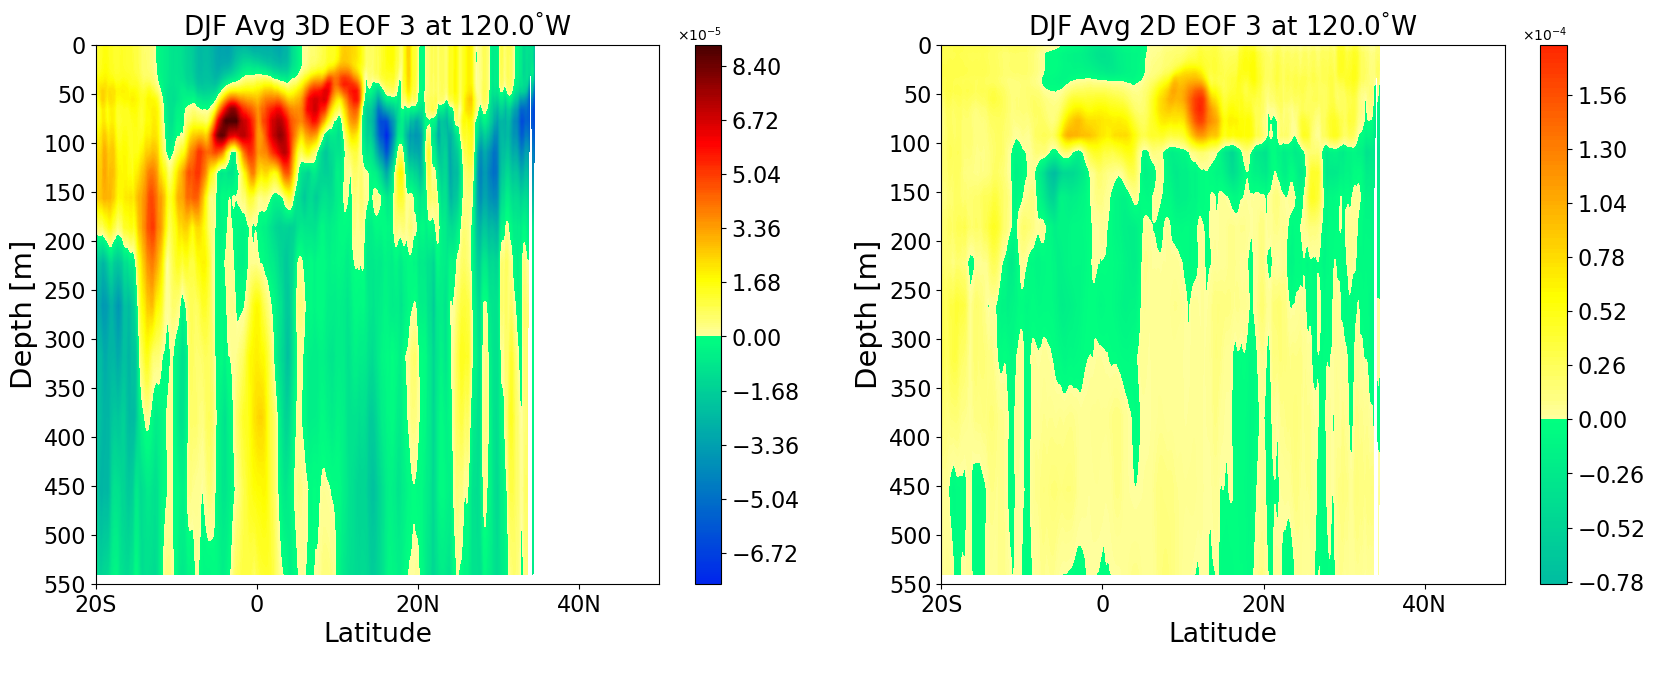

In [9]:
# ############ 120

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20., 7.))

depth_end = 32  # stop at this depth for the plot
clip2D = 0.0003
clip3D = 0.00009
lon_ind = 2880
lat_ind = 720
lat_end = 1560

cl2 = cut_lat[lat_ind:lat_end]
Z = EOF[:depth_end, lat_ind:lat_end, lon_ind]
surface = np.clip(Z, -clip2D, clip2D)

Z3D = EOF3D[:depth_end, lat_ind:lat_end, lon_ind]
surface3D = np.clip(Z3D, -clip3D, clip3D)

# Create two separate normalizations
norm2D = mpl.colors.Normalize(vmin=-clip2D, vmax=clip2D)
norm3D = mpl.colors.Normalize(vmin=-clip3D, vmax=clip3D)

def plot_eof(ax, data, plotName, norm):
    cf = ax.contourf(cl2, 0 - np.array(cut_depths[:depth_end]), data, 300, cmap=newcmp2, norm=norm)

    # Axis formatting
    lon_name = convert_longitude(cut_lon[lon_ind])
    ax.set_title(f"DJF Avg {plotName} EOF {mode} at {lon_name}", size=title_sz)

    ax.set_xlabel("Latitude\n", size=label_sz+3)
    lat_name = []
    spacing = 20
    for ii in cl2[0::12*spacing]:
        lat_name.append(format_latitude(int(ii)))
    ax.set_xticks(cl2[0::12*spacing])
    ax.set_xticklabels(lat_name, fontsize=label_sz)

    ax.set_ylabel('Depth [m]', size=label_sz+5)
    step = 50
    y_labels = ax.get_yticks()
    dep_names = np.arange(0, -y_labels[0], step).astype(int)
    ax.set_yticks(-dep_names)
    ax.set_yticklabels(dep_names.astype(str).tolist(), fontsize=label_sz)

    return cf

# Plot both panels
cf2D = plot_eof(ax2, surface, "2D", norm2D)
cf3D = plot_eof(ax1, surface3D, "3D", norm3D)

# Add separate colorbars for each plot
cbar2D = fig.colorbar(cf2D, ax=ax2, orientation='vertical', format=mpl.ticker.ScalarFormatter(useMathText=True))
cbar2D.ax.tick_params(labelsize=label_sz)
cbar2D.formatter.set_powerlimits((0, 0))
cbar2D.update_ticks()

cbar3D = fig.colorbar(cf3D, ax=ax1, orientation='vertical', format=mpl.ticker.ScalarFormatter(useMathText=True))
cbar3D.ax.tick_params(labelsize=label_sz)
cbar3D.formatter.set_powerlimits((0, 0))
cbar3D.update_ticks()

# Save and show
savePath = f"D:/SCIL/Paper Figs/Global/Cross Sections/DJF Avg 2D vs 3D EOF {mode} at 120W"
# plt.tight_layout()
#plt.savefig(savePath)
plt.show()


# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20., 7.))

# depth_end = 32  # stop at this depth for the plot
# clip2D = 0.0003
# clip3D = 0.00009
# lon_ind = 2880
# lat_ind = 720
# lat_end = 1560

# cl2 = cut_lat[lat_ind:lat_end]
# Z = EOF[:depth_end, lat_ind:lat_end, lon_ind]
# surface = np.clip(Z, -clip2D, clip2D)


# Z3D = EOF3D[:depth_end, lat_ind:lat_end, lon_ind]
# surface3D = np.clip(Z3D, -clip3D, clip3D)

# norm = mpl.colors.Normalize(vmin=-zlim, vmax=zlim)

# def plot_eof(ax, data, plotName):
#     cf = ax.contourf(cl2, 0 - np.array(cut_depths[:depth_end]), data, 300, cmap=newcmp2, norm=norm)

#     # Axis formatting
#     lon_name = convert_longitude(cut_lon[lon_ind])
#     ax.set_title(f"DJF Avg {plotName} EOF {mode} at {lon_name}", size=title_sz)

#     ax.set_xlabel("Latitude\n", size=label_sz+3)
#     lat_name = []
#     spacing = 20
#     # while len(cl2[0::12*spacing]) > 8:
#     #     spacing += 2
#     # for i in cl2[0::12*spacing]:
#     #     lat_name.append(f"{int(abs(i))}{'S' if i < 0 else 'N'}")
#     # ax.set_xticks(cl2[0::12*spacing])
#     # ax.set_xticklabels(lat_name, fontsize=label_sz)
#     for ii in cl2[0::12*spacing]:
#         lat_name.append(format_latitude(int(ii)))
#     ax.set_xticks(cl2[0::12*spacing])
#     ax.set_xticklabels(lat_name, fontsize=label_sz)


#     # # X-axis labels (longitude)
#     # spacing = 20
#     # lon_labels = []
    
    

#     ax.set_ylabel('Depth [m]', size=label_sz+5)
#     step = 50
#     y_labels = ax.get_yticks()
#     dep_names = np.arange(0, -y_labels[0], step).astype(int)
#     ax.set_yticks(-dep_names)
#     ax.set_yticklabels(dep_names.astype(str).tolist(), fontsize=label_sz)

#     return cf




# # Plot both panels
# cf1 = plot_eof(ax2, surface, "2D")
# cf2 = plot_eof(ax1, surface3D, "3D")

# # Add a colorbar that spans both subplots
# cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=newcmp2), ax=[ax1, ax2], orientation='vertical', format=mpl.ticker.ScalarFormatter(useMathText=True))
# cbar.ax.yaxis.get_offset_text().set_fontsize(label_sz)
# cbar.ax.yaxis.OFFSETTEXTPAD = 11
# cbar.ax.yaxis.set_offset_position('left')
# cbar.ax.tick_params(labelsize=label_sz)
# cbar.formatter.set_powerlimits((0, 0))
# cbar.update_ticks()


# # Save and show
# savePath = f"D:/SCIL/Paper Figs/Global/Cross Sections/DJF Avg 2D vs 3D EOF {mode} at 120W"
# # plt.tight_layout()
# #plt.savefig(savePath)
# plt.show()


## 160E

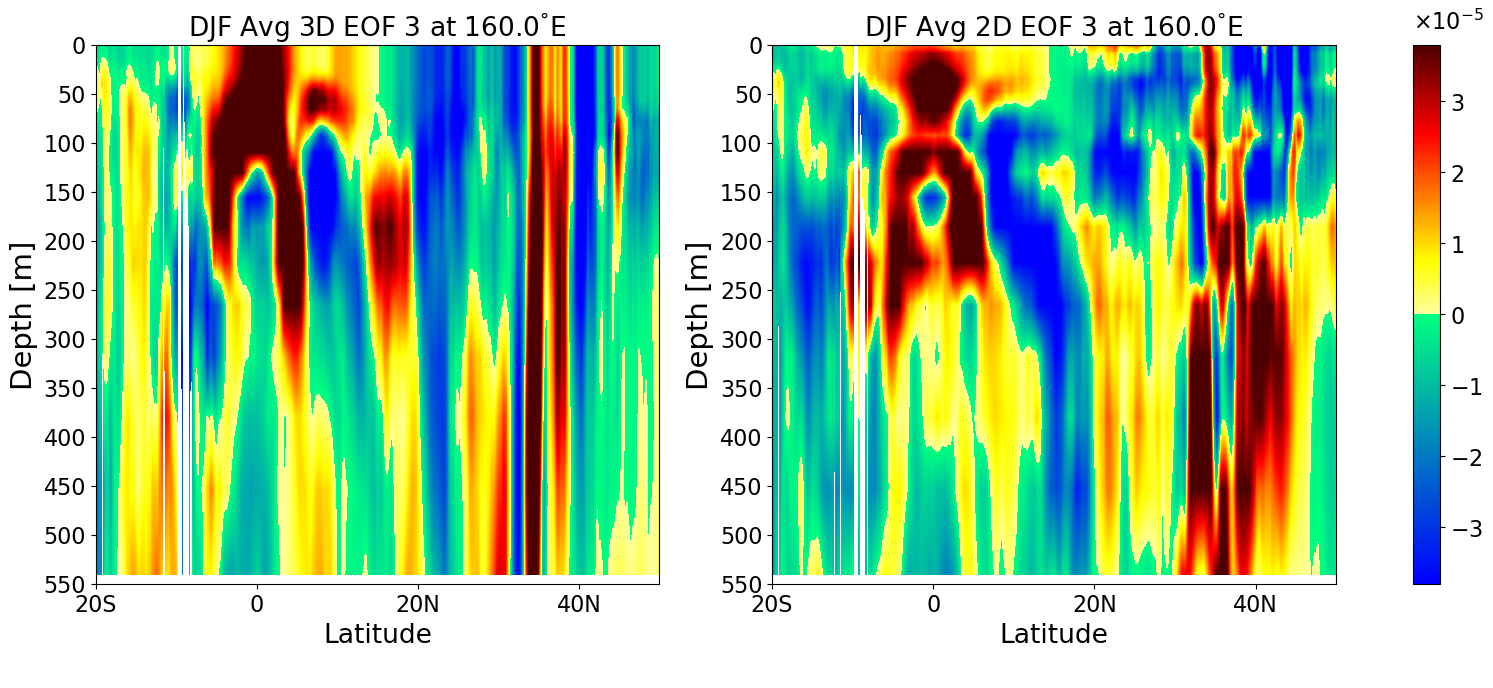

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20., 7.))

depth_end = 32  # stop at this depth for the plot



zlim = 0.000038



lon_ind = 1920
lat_ind = 720
lat_end = 1560

cl2 = cut_lat[lat_ind:lat_end]
Z = EOF[:depth_end, lat_ind:lat_end, lon_ind]
surface = np.clip(Z, -zlim, zlim)


Z3D = EOF3D[:depth_end, lat_ind:lat_end, lon_ind]
surface3D = np.clip(Z3D, -zlim, zlim)

norm = mpl.colors.Normalize(vmin=-zlim, vmax=zlim)

def plot_eof(ax, data, plotName):
    cf = ax.contourf(cl2, 0 - np.array(cut_depths[:depth_end]), data, 300, cmap=newcmp2, norm=norm)

    # Axis formatting
    lon_name = convert_longitude(cut_lon[lon_ind])
    ax.set_title(f"DJF Avg {plotName} EOF {mode} at {lon_name}", size=title_sz)

    ax.set_xlabel("Latitude\n", size=label_sz+3)
    lat_name = []
    spacing = 20
    # while len(cl2[0::12*spacing]) > 8:
    #     spacing += 2
    # for i in cl2[0::12*spacing]:
    #     lat_name.append(f"{int(abs(i))}{'S' if i < 0 else 'N'}")
    # ax.set_xticks(cl2[0::12*spacing])
    # ax.set_xticklabels(lat_name, fontsize=label_sz)
    for ii in cl2[0::12*spacing]:
        lat_name.append(format_latitude(int(ii)))
    ax.set_xticks(cl2[0::12*spacing])
    ax.set_xticklabels(lat_name, fontsize=label_sz)


    # # X-axis labels (longitude)
    # spacing = 20
    # lon_labels = []
    
    

    ax.set_ylabel('Depth [m]', size=label_sz+5)
    step = 50
    y_labels = ax.get_yticks()
    dep_names = np.arange(0, -y_labels[0], step).astype(int)
    ax.set_yticks(-dep_names)
    ax.set_yticklabels(dep_names.astype(str).tolist(), fontsize=label_sz)

    return cf




# Plot both panels
cf1 = plot_eof(ax2, surface, "2D")
cf2 = plot_eof(ax1, surface3D, "3D")

# Add a colorbar that spans both subplots
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=newcmp2), ax=[ax1, ax2], orientation='vertical', format=mpl.ticker.ScalarFormatter(useMathText=True))
cbar.ax.yaxis.get_offset_text().set_fontsize(label_sz)
cbar.ax.yaxis.OFFSETTEXTPAD = 11
cbar.ax.yaxis.set_offset_position('left')
cbar.ax.tick_params(labelsize=label_sz)
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()


# Save and show
savePath = f"D:/SCIL/Paper Figs/Global/Cross Sections/DJF Avg 2D vs 3D EOF {mode} at 160E"
# plt.tight_layout()
#plt.savefig(savePath)
plt.show()

## Equator

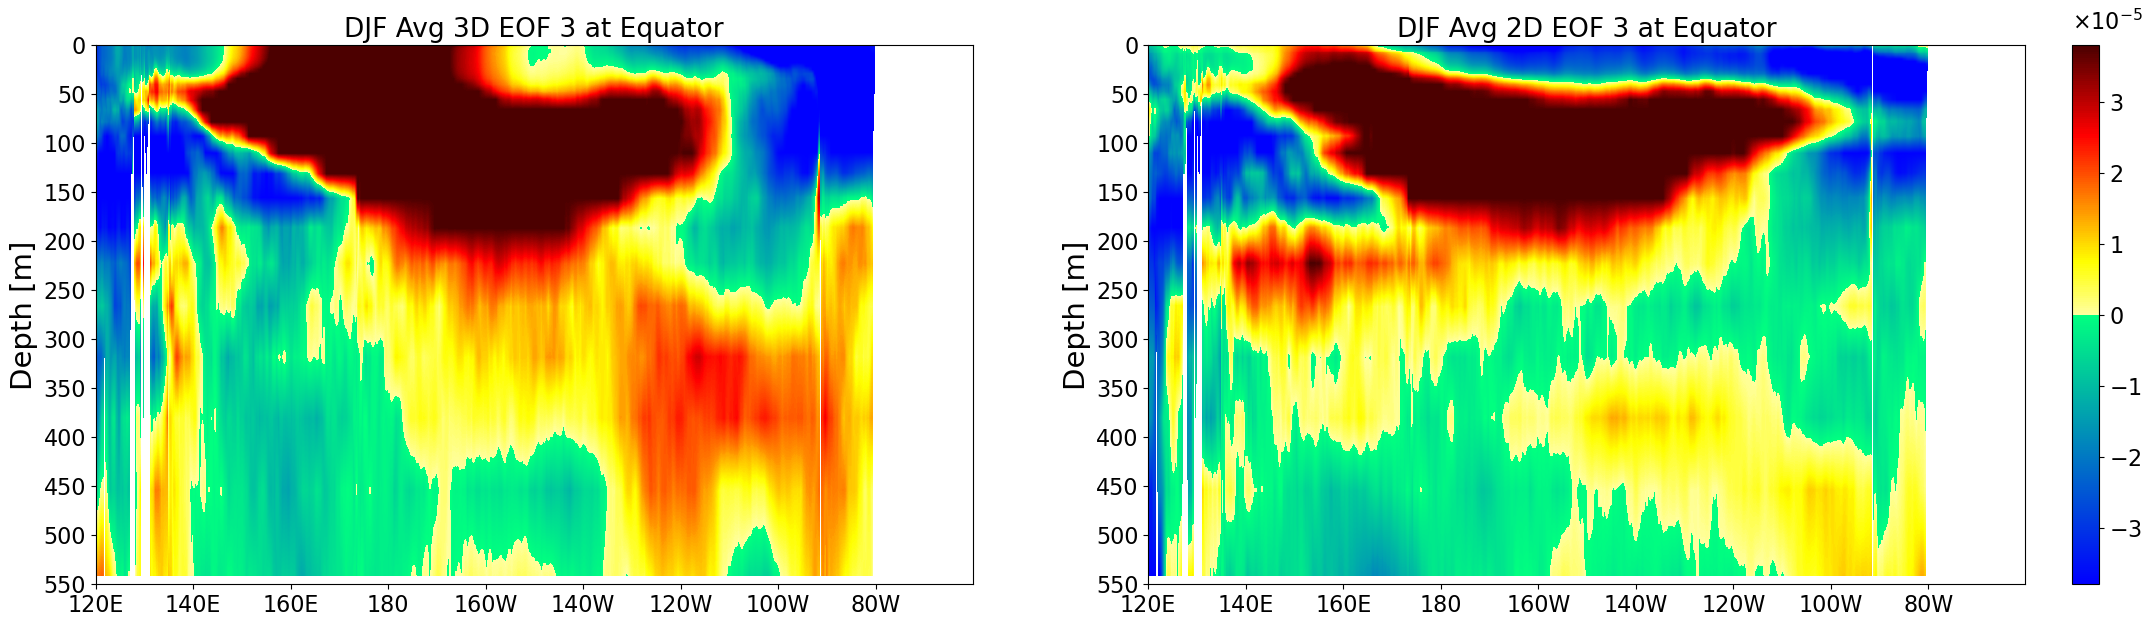

In [7]:

# Set up figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30., 7.))

depth_end = 32  # stop at this depth for the plot
zlim = 0.000038

lat_ind = 960

lon_ind = 1440
lon_end = 3600

cl2 = cut_lon[lon_ind:lon_end]
Z = EOF[:depth_end, lat_ind, lon_ind:lon_end]
surface = np.clip(Z, -zlim, zlim)


Z3D = EOF3D[:depth_end, lat_ind, lon_ind:lon_end]
surface3D = np.clip(Z3D, -zlim, zlim)

norm = mpl.colors.Normalize(vmin=-zlim, vmax=zlim)

def plot_eof(ax, data, plotName):
    cf = ax.contourf(cl2, 0 - np.array(cut_depths[:depth_end]), data, 300, cmap=newcmp2, norm=norm)

    # X-axis labels (longitude)
    spacing = 20
    lon_labels = []
    for ii in cl2[0::12*spacing]:
        lon_labels.append(format_longitude(int(ii)))
    ax.set_xticks(cl2[0::12*spacing])
    ax.set_xticklabels(lon_labels, fontsize=label_sz)

    # Y-axis labels (depth)
    ax.set_ylabel('Depth [m]', size=label_sz+5)
    step = 50
    y_labels = ax.get_yticks()
    dep_names = np.arange(0, -y_labels[0], step).astype(int)
    ax.set_yticks(-dep_names)
    ax.set_yticklabels(dep_names.astype(str).tolist(), fontsize=label_sz)

    lat_name = get_lat_names(lat_ind)
    ax.set_title(f"DJF Avg {plotName} EOF {mode} at {lat_name}", size=title_sz)
    return cf

# Plot both panels
cf1 = plot_eof(ax2, surface, "2D")
cf2 = plot_eof(ax1, surface3D, "3D")

# Shared colorbar
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=newcmp2), ax=[ax1, ax2],
                    format=mpl.ticker.ScalarFormatter(useMathText=True),
                    orientation='vertical', pad=0.02)
cbar.ax.yaxis.get_offset_text().set_fontsize(label_sz)
cbar.ax.yaxis.OFFSETTEXTPAD = 11
cbar.ax.yaxis.set_offset_position('left')
cbar.ax.tick_params(labelsize=label_sz)
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()

# Save and show
savePath = f"D:/SCIL/Paper Figs/Global/Cross Sections/DJF Avg 2D vs 3D EOF {mode} at Equator"
# plt.tight_layout()
#plt.savefig(savePath, bbox_inches='tight')
plt.show()


## Cube

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
from mpl_toolkits.basemap import Basemap
from scipy.stats import linregress

# --- Config ---
iz = 0
depth_end = 32
lat_start, lat_end = 960, 1812
lon_start, lon_end = 720, 3492
zlim = 0.000038

lonNum = lon_end/12

# --- Z-limits ---
zlim_left = 0.00009
zlim_right = 0.0003




# --- Slice cube ---


#cube = EOF[:depth_end, lat_start:lat_end, lon_start:lon_end]  # shape: (32, 840, 480)

# 2D EOF
surface = EOF[0, lat_start:lat_end, lon_start:lon_end]
lat_depth = EOF[:depth_end, lat_start, lon_start:lon_end]
lon_depth = EOF[:depth_end, lat_start:lat_end, lon_end]

# 3D EOF
surface3D = EOF3D[0, lat_start:lat_end, lon_start:lon_end]
lat_depth3D = EOF3D[:depth_end, lat_start, lon_start:lon_end]
lon_depth3D = EOF3D[:depth_end, lat_start:lat_end, lon_end]


#depths = np.array(cut_depths[:depth_end])
depths = np.abs(cut_depths[:depth_end])
lats = np.array(cut_lat[lat_start:lat_end])
lons = np.array(cut_lon[lon_start:lon_end])

X, Y, Z = np.meshgrid(lons, lats, -depths)

# --- Clipping and color norm ---


#cube_clipped = np.clip(cube, -zlim, zlim)
norm = mpl.colors.Normalize(vmin=-zlim, vmax=zlim)
# --- Clipping and color norm ---
norm_left = mpl.colors.Normalize(vmin=-zlim_left, vmax=zlim_left)
norm_right = mpl.colors.Normalize(vmin=-zlim_right, vmax=zlim_right)


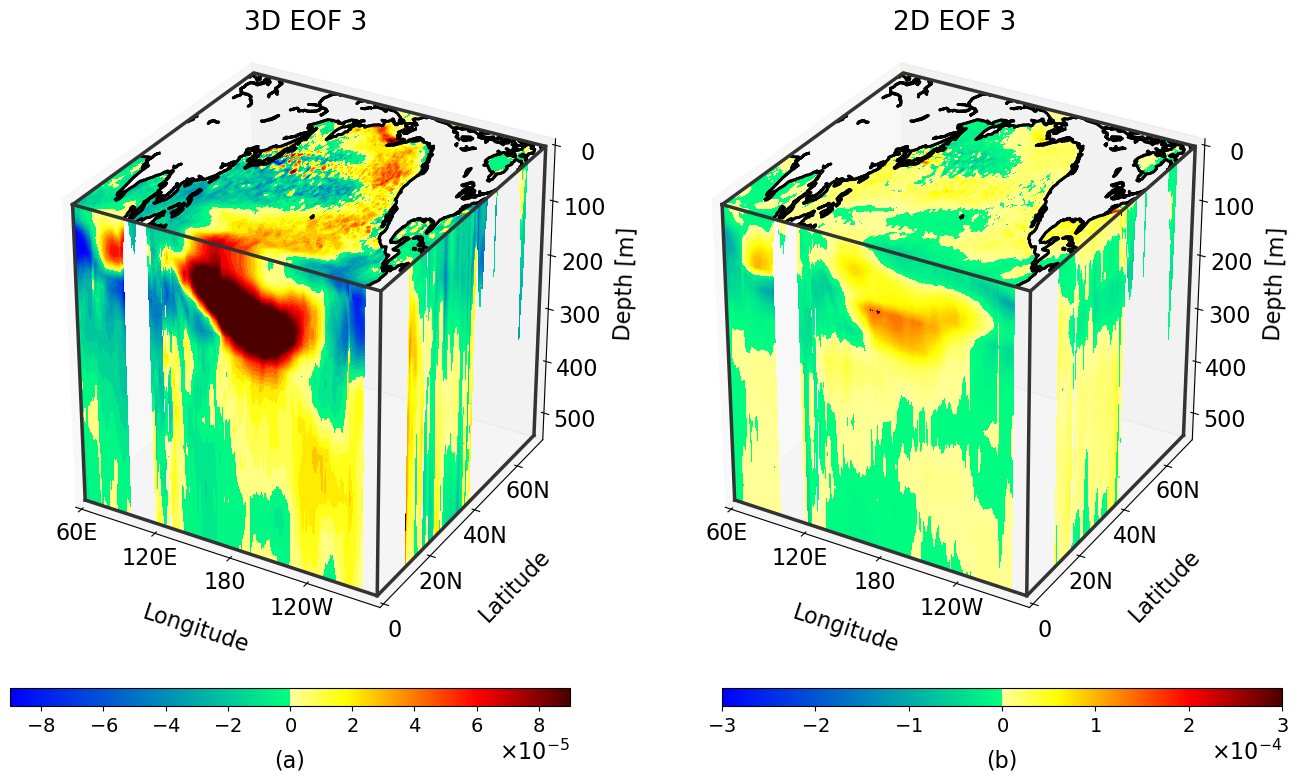

In [12]:
# --- Setup Figure ---
fig = plt.figure(figsize=(16, 9))
plt.subplots_adjust(wspace=0.1)
levels = 50

# --- Tick Configuration ---
lon_ticks   = np.arange(60, lonNum, 60)
lat_ticks   = np.arange(0, 81, 20)
depth_ticks = np.arange(0, depths.max() + 1, 100)

# --- Z-limits ---
# zlim_left = 0.0003
# zlim_right = 0.00009

# --- Clipping and color norm ---


# norm_left = mpl.colors.Normalize(vmin=-zlim_left, vmax=zlim_left)
# norm_right = mpl.colors.Normalize(vmin=-zlim_right, vmax=zlim_right)

# --- Plot Helper Function ---
def configure_3d_axes(ax, xticks, yticks, zticks, title):
    ax.grid(False)
    ax.set_xticks(xticks, labels=[format_longitude(int(l)) for l in xticks], fontsize=label_sz)
    ax.set_yticks(yticks, labels=[format_latitude(int(l)) for l in yticks], fontsize=label_sz)
    ax.set_zticks(-zticks, labels=[f"{t:.0f}" for t in zticks], fontsize=label_sz)
    ax.tick_params(axis='x', pad=-2, labelsize=label_sz)
    ax.tick_params(axis='y', pad=0,  labelsize=label_sz)
    ax.tick_params(axis='z', pad=7,  labelsize=label_sz)
    ax.set_xlabel('Longitude', fontsize=label_sz, labelpad=13)
    ax.set_ylabel('Latitude', fontsize=label_sz, labelpad=16)
    ax.set_zlabel('Depth [m]', fontsize=label_sz, labelpad=16, rotation=0)
    ax.set_title(title, fontsize=title_sz)
    ax.set_xlim(lons.min(), lons.max())
    ax.set_ylim(lats.min(), lats.max())
    ax.set_zlim(-depths.max(), 0)
    ax.set_box_aspect((1, 1, 1))
    ax.view_init(elev=30, azim=-60)

    # Box edges
    xmin, xmax = lons.min(), lons.max()
    ymin, ymax = lats.min(), lats.max()
    zmin, zmax = -depths.max(), 0
    edges_kw = dict(color='0.2', linewidth=2.5, zorder=100)

    ax.plot([xmin, xmax, xmax], [ymin, ymin, ymax], [zmin]*3, **edges_kw)
    ax.plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin], [zmax]*5, **edges_kw)
    for x in (xmin, xmax):
        for y in (ymin, ymax):
            if not (x == xmin and y == ymax):  # skip back-left
                ax.plot([x, x], [y, y], [zmin, zmax], **edges_kw)

# === 3D EOF Plot (Left) ===
ax2 = fig.add_subplot(121, projection='3d')

cs2 = ax2.contourf(X[:, :, 0], Y[:, :, 0], surface3D, zdir='z', offset=-depths[iz],
                   levels=levels, cmap=newcmp2, norm=norm_left, alpha=1, extend='both', vmin=-zlim_left, vmax=zlim_left)
ax2.contourf(X[0, :, :], lat_depth3D.T, Z[0, :, :], zdir='y', levels=levels, cmap=newcmp2,
             norm=norm_left, alpha=1, vmin=-zlim_left, vmax=zlim_left, extend='both')
ax2.contourf(lon_depth3D.T, Y[:, -1, :], Z[:, -1, :], zdir='x', offset=lonNum, levels=levels,
             cmap=newcmp2, norm=norm_left, alpha=1, vmin=-zlim_left, vmax=zlim_left, extend='both')

m2 = Basemap(projection='cyl', llcrnrlon=lons.min(), urcrnrlon=lons.max(),
             llcrnrlat=lats.min(), urcrnrlat=lats.max())
ax2.add_collection3d(m2.drawcoastlines(linewidth=2), zs=-depths[iz], zdir='z')

configure_3d_axes(ax2, lon_ticks, lat_ticks, depth_ticks, f"3D EOF {mode}")
#ax2.text2D(0.02, 0.95, "(a)", transform=ax2.transAxes, fontsize=18, fontweight='bold')

# === 2D EOF Plot (Right) ===
ax = fig.add_subplot(122, projection='3d')

cs = ax.contourf(X[:, :, 0], Y[:, :, 0], surface, zdir='z', offset=-depths[iz],
                 levels=levels, cmap=newcmp2, norm=norm_right, alpha=1, extend='both', vmin=-zlim_right, vmax=zlim_right)
ax.contourf(X[0, :, :], lat_depth.T, Z[0, :, :], zdir='y', levels=levels,
            cmap=newcmp2, norm=norm_right, alpha=1, vmin=-zlim_right, vmax=zlim_right, extend='both')
ax.contourf(lon_depth.T, Y[:, -1, :], Z[:, -1, :], zdir='x', offset=lonNum, levels=levels,
            cmap=newcmp2, norm=norm_right, alpha=1, vmin=-zlim_right, vmax=zlim_right, extend='both')

m = Basemap(projection='cyl', llcrnrlon=lons.min(), urcrnrlon=lons.max(),
            llcrnrlat=lats.min(), urcrnrlat=lats.max())
ax.add_collection3d(m.drawcoastlines(linewidth=2), zs=-depths[iz], zdir='z')

configure_3d_axes(ax, lon_ticks, lat_ticks, depth_ticks, f"2D EOF {mode}")
# ax.text2D(0.02, 0.95, "(b)", transform=ax.transAxes, fontsize=18, fontweight='bold')

# === Separate Colorbars BELOW the plots ===

# Left colorbar (under left plot)
sm_left = mpl.cm.ScalarMappable(norm=norm_left, cmap=newcmp2)
sm_left.set_array([])
cbar_ax_left = fig.add_axes([0.125, 0.08, 0.35, 0.02])  # [left, bottom, width, height]
cbar_left = fig.colorbar(sm_left, cax=cbar_ax_left, orientation='horizontal',
                         format=mpl.ticker.ScalarFormatter(useMathText=True))
cbar_left.ax.tick_params(labelsize=14, direction='out')
cbar_left.ax.xaxis.get_offset_text().set_fontsize(label_sz)
cbar_left.formatter.set_powerlimits((0, 0))
cbar_left.update_ticks()
cbar_left.set_label("(a)", fontsize=16, labelpad=10, loc='center')

# Right colorbar (under right plot)
sm_right = mpl.cm.ScalarMappable(norm=norm_right, cmap=newcmp2)
sm_right.set_array([])
cbar_ax_right = fig.add_axes([0.57, 0.08, 0.35, 0.02])  # [left, bottom, width, height]
cbar_right = fig.colorbar(sm_right, cax=cbar_ax_right, orientation='horizontal',
                          format=mpl.ticker.ScalarFormatter(useMathText=True))
cbar_right.ax.tick_params(labelsize=14, direction='out')
cbar_right.ax.xaxis.get_offset_text().set_fontsize(label_sz)
cbar_right.formatter.set_powerlimits((0, 0))
cbar_right.update_ticks()
cbar_right.set_label("(b)", fontsize=16, labelpad=10, loc='center')

# --- Show Plot ---
saveName = "D:/SCIL/Paper Figs/" + region + "/Cross Sections/Cube_" + region + "_mode_" + str(mode)
plt.savefig(saveName, bbox_inches='tight', dpi = 700)
plt.show()


## Representative Layer Cube

In [87]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
from mpl_toolkits.basemap import Basemap
from scipy.stats import linregress



# --- Config ---
iz = 26                            # Start depth
depth_end = 29                     # End Depth
lat_start, lat_end = 600, 1812     # Add/subtract # degrees * 12 to change range 
lon_start, lon_end = 1920, 2892    # Add/subtract # degrees * 12 to change range
zlim = 0.000038                    # Adjust for better clip

# --- Create cross section slices ---


# 2D EOF
surface = EOF[iz, lat_start:lat_end, lon_start:lon_end]
lat_depth = EOF[iz:depth_end, lat_start, lon_start:lon_end]
lon_depth = EOF[iz:depth_end, lat_start:lat_end, lon_end]

# 3D EOF
surface3D = EOF3D[iz, lat_start:lat_end, lon_start:lon_end]
lat_depth3D = EOF3D[iz:depth_end, lat_start, lon_start:lon_end]
lon_depth3D = EOF3D[iz:depth_end, lat_start:lat_end, lon_end]


# Create coordinate grid
depths = np.abs(cut_depths[iz:depth_end])
lats = np.array(cut_lat[lat_start:lat_end])
lons = np.array(cut_lon[lon_start:lon_end])


X, Y, Z = np.meshgrid(lons, lats, -depths)

# --- Color norm ---
norm = mpl.colors.Normalize(vmin=-zlim, vmax=zlim)

In [47]:
print("shapes:", X.shape, Y.shape, Z.shape)

shapes: (852, 492, 3) (852, 492, 3) (852, 492, 3)


In [48]:
print(Z[iz, :, :].shape, X[0, :, :].shape)

(492, 3) (492, 3)


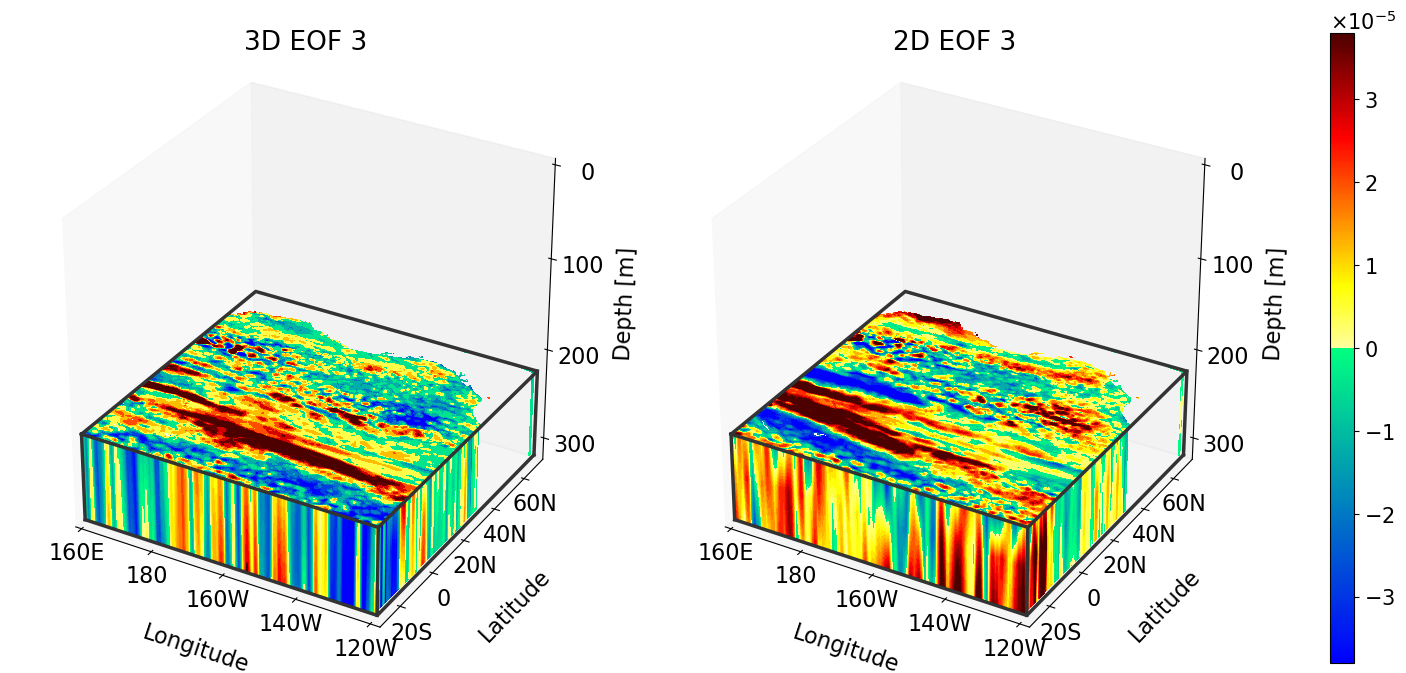

In [92]:
# --- Setup Figure ---
fig = plt.figure(figsize=(16, 9))
plt.subplots_adjust(wspace=0.1)
vmin, vmax = -0.000038, 0.000038 # Change to scale better
levels = 50



# --- Tick Configuration ---
# These are based on the cross sectional area and determine axis labels
lon_ticks   = np.arange(160, 241, 20)
lat_ticks   = np.arange(-20, 81, 20)
depth_ticks = np.arange(0, depths.max() + 1, 100)


# --- Plot Helper Function ---
def configure_3d_axes(ax, xticks, yticks, zticks, title):
    ax.grid(False)
    ax.set_xticks(xticks, labels=[format_longitude(int(l)) for l in xticks], fontsize=label_sz) # Requires format_longitude function to remove degree symbol
    ax.set_yticks(yticks, labels=[format_latitude(int(l)) for l in yticks], fontsize=label_sz)  # Requires format_latitude function to remove degree symbol
    ax.set_zticks(-zticks, labels=[f"{t:.0f}" for t in zticks], fontsize=label_sz)
    ax.tick_params(axis='x', pad=-2, labelsize=label_sz)
    ax.tick_params(axis='y', pad=0,  labelsize=label_sz)
    ax.tick_params(axis='z', pad=7,  labelsize=label_sz)
    ax.set_xlabel('Longitude', fontsize=label_sz, labelpad=13)
    ax.set_ylabel('Latitude', fontsize=label_sz, labelpad=16)
    ax.set_zlabel('Depth [m]', fontsize=label_sz, labelpad=16, rotation=0)
    ax.set_title(title, fontsize=title_sz)
    ax.set_xlim(lons.min(), lons.max())
    ax.set_ylim(lats.min(), lats.max())
    ax.set_zlim(-depths.max(), 0)
    ax.set_box_aspect((1, 1, 1))
    ax.view_init(elev=30, azim=-60)
    
    
    # appearance and formatting
    xmin, xmax = lons.min(), lons.max()
    ymin, ymax = lats.min(), lats.max()
    zmin, zmax = -depths.max(),   -depths.min() 

    #############################
    # draw edges of 3d box
    #############################
    edges_kw = dict(color='0.2', linewidth=2.5, zorder=100)
    
    # bottom face
    ax.plot(
        [xmin, xmax, xmax],
        [ymin, ymin, ymax],
        [zmin]*3,
        **edges_kw
    )
    
    # top face
    ax.plot(
        [xmin, xmax, xmax, xmin, xmin],
        [ymin, ymin, ymax, ymax, ymin],
        [zmax]*5,
        **edges_kw
    )
    
    # Vertical edges (excluding back-left)
    for x in (xmin, xmax):
        for y in (ymin, ymax):
            if not (x == xmin and y == ymax):  # skip back-left
                ax.plot(
                    [x, x],
                    [y, y],
                    [zmin, zmax],
                    **edges_kw
                )



# === 3D EOF Plot (Left) ===
ax2 = fig.add_subplot(121, projection='3d')


Zy = Z[iz, :, :]

# Contours
cs2 = ax2.contourf(X[:, :, 0], Y[:, :, 0], surface3D, zdir='z',offset=-depths[0],
                   levels=levels, cmap=newcmp2, norm=norm, alpha=1, vmin=vmin, vmax=vmax, extend='both')
ax2.contourf(X[0, :, :], lat_depth3D.T, Zy, zdir='y', levels=levels, cmap=newcmp2, offset=-30,
             norm=norm, alpha=1, vmin=vmin, vmax=vmax, extend='both')
ax2.contourf(lon_depth3D.T, Y[:, -1, :], Z[:, -1, :], zdir='x', offset=240, levels=levels,
             cmap=newcmp2, norm=norm, alpha=1, vmin=vmin, vmax=vmax, extend='both')

# Coastlines
# m2 = Basemap(projection='cyl', llcrnrlon=lons.min(), urcrnrlon=lons.max(),
#              llcrnrlat=lats.min(), urcrnrlat=lats.max())
# ax2.add_collection3d(m2.drawcoastlines(linewidth=2), zs=-depths[iz], zdir='z')

configure_3d_axes(ax2, lon_ticks, lat_ticks, depth_ticks, f"3D EOF {mode}")

# === 2D EOF Plot (Right) ===
ax = fig.add_subplot(122, projection='3d')

# Contours
cs = ax.contourf(X[:, :, 0], Y[:, :, 0], surface, zdir='z', offset=-depths[0],
                 levels=levels, cmap=newcmp2, norm=norm, alpha=1, vmin=vmin, vmax=vmax, extend='both')
ax.contourf(X[0, :, :], lat_depth.T, Z[iz, :, :], zdir='y', levels=levels,offset = -30,
            cmap=newcmp2, norm=norm, alpha=1, vmin=vmin, vmax=vmax, extend='both')
ax.contourf(lon_depth.T, Y[:, -1, :], Z[:, -1, :], zdir='x', offset=240, levels=levels,
            cmap=newcmp2, norm=norm, alpha=1, vmin=vmin, vmax=vmax, extend='both')

# # Coastlines
# m = Basemap(projection='cyl', llcrnrlon=lons.min(), urcrnrlon=lons.max(),
#             llcrnrlat=lats.min(), urcrnrlat=lats.max())
# ax.add_collection3d(m.drawcoastlines(linewidth=2), zs=-depths[iz], zdir='z')

configure_3d_axes(ax, lon_ticks, lat_ticks, depth_ticks, f"2D EOF {mode}")

# === Shared Colorbar ===
sm = mpl.cm.ScalarMappable(norm=norm, cmap=newcmp2)
sm.set_array([])

cbar_ax = fig.add_axes([0.95, 0.15, 0.015, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(sm, cax=cbar_ax, format=mpl.ticker.ScalarFormatter(useMathText=True), shrink=0.4)
cbar.ax.tick_params(labelsize=15)
cbar.ax.yaxis.get_offset_text().set_fontsize(15)
cbar.ax.yaxis.set_offset_position('left')
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()

# --- Show Plot ---

saveName = "D:/SCIL/Paper Figs/" + region + "/Cross Sections/Cube_MVT_" + region + "_mode_" + str(mode)
    
#print(saveName)
plt.savefig(saveName, bbox_inches='tight')


plt.show()




In [56]:
depth_ticks

array([ 26., 126., 226.])